(0.0, 3.0)

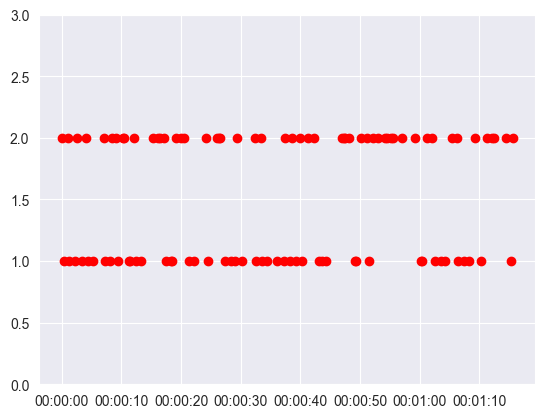

In [38]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import LSTM, Input, Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 假设 df 是包含 'player1_winrate', 'player2_winrate', 'timestamp', 'outcome' 的 DataFrame
# 其中 'outcome' 是目标变量，表示比赛结果

# 数据预处理
# 这里需要添加将时间戳转换为可用特征的代码
# 例如，提取时间戳的日、月、小时等

original = pd.read_csv("../data/original/Wimbledon_featured_matches.csv")

data = original[["match_id", "elapsed_time", "point_victor"]].copy()

data = data.loc[data["match_id"] == "2023-wimbledon-1301"]

data = data.rename(columns={"elapsed_time": "ds", "point_victor": "y"})
data["ds"] = pd.to_datetime(data["ds"], format="%H:%M:%S")

# 分割数据集
X = data.drop('outcome', axis=1)
y = data['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# LSTM 模型构建
# 假设我们只用时间戳作为 LSTM 的输入
timestamp_input = Input(shape=(X_train.shape[1], 1))
lstm_out = LSTM(50, activation='relu')(timestamp_input)
lstm_model = Model(inputs=timestamp_input, outputs=lstm_out)

# 训练 LSTM 模型
# 此处需要根据你的数据调整生成器的参数
generator = TimeseriesGenerator(X_train['timestamp'], y_train, length=10, batch_size=20)
lstm_model.compile(optimizer='adam', loss='binary_crossentropy')
lstm_model.fit_generator(generator, steps_per_epoch=1, epochs=10, verbose=0)

# 预测时间特征
train_timestamp_features = lstm_model.predict(X_train['timestamp'])
test_timestamp_features = lstm_model.predict(X_test['timestamp'])

# 结合 LSTM 输出和其他特征
X_train_combined = np.concatenate((train_timestamp_features, X_train[['player1_winrate', 'player2_winrate']].values), axis=1)
X_test_combined = np.concatenate((test_timestamp_features, X_test[['player1_winrate', 'player2_winrate']].values), axis=1)

# XGBoost 模型
xgb_model = XGBClassifier()
xgb_model.fit(X_train_combined, y_train)

# 预测和评估
y_pred = xgb_model.predict(X_test_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")